# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
# from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from sklearn.tree import plot_tree
from collections import Counter
import time

import warnings
import sys
warnings.filterwarnings("ignore", category=FutureWarning)

In [15]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [112]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [6]:
#Check for missing values
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [115]:
#Check for duplicates 
df.duplicated().sum()

12

In [116]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [117]:
df['age'].value_counts()

age
31    1947
32    1846
33    1833
36    1780
35    1759
      ... 
89       2
91       2
94       1
87       1
95       1
Name: count, Length: 78, dtype: int64

<Axes: xlabel='y', ylabel='age'>

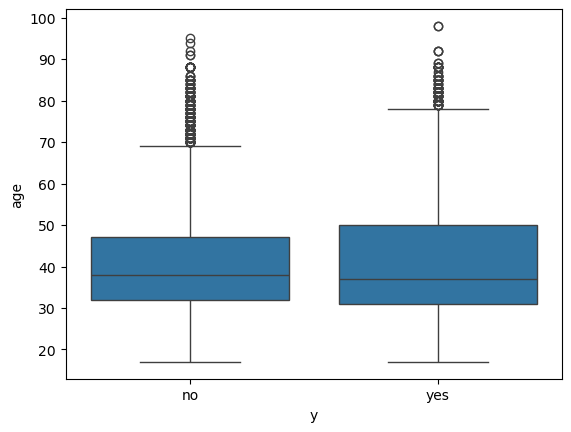

In [118]:
sns.boxplot(x='y', y='age', data=df)

<Axes: xlabel='age', ylabel='Count'>

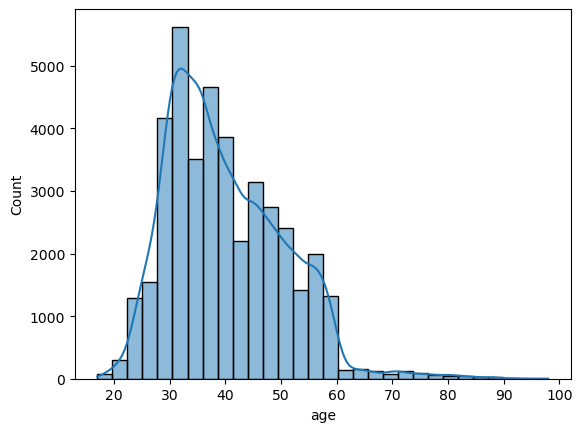

In [119]:
sns.histplot(df['age'], bins=30, kde=True)

In [120]:
df['contact'].value_counts()

contact
cellular     26144
telephone    15044
Name: count, dtype: int64

In [121]:
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

age: 78 unique values
job: 12 unique values
marital: 4 unique values
education: 8 unique values
default: 3 unique values
housing: 3 unique values
loan: 3 unique values
contact: 2 unique values
month: 10 unique values
day_of_week: 5 unique values
duration: 1544 unique values
campaign: 42 unique values
pdays: 27 unique values
previous: 8 unique values
poutcome: 3 unique values
emp.var.rate: 10 unique values
cons.price.idx: 26 unique values
cons.conf.idx: 26 unique values
euribor3m: 316 unique values
nr.employed: 11 unique values
y: 2 unique values


In [90]:
for col in df.select_dtypes(include='object').columns:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())


job value counts:
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

marital value counts:
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64

education value counts:
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

housing value counts:
housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64

loan value counts:
loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64

contact value counts:
contact
cellular    

In [123]:
df.isnull().sum()


age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The dataset comes from a Portuguese bank's direct marketing campaigns, where human agents called potential clients to convince them to subscribe to a long-term deposit (a type of savings account with fixed interest).

#### Why it matters ####
- Calling customers costs time and money (agents, phone usage, etc.)

- Only a small percentage of people actually subscribe (~11%)

- The bank wants to reduce the number of failed calls and focus efforts on people who are more likely to say yes

#### Business Objective ####

The objective is to build a predictive model that helps the bank identify which customers are most likely to subscribe to a term deposit, so the marketing team can target those customers more efficiently and reduce wasted resources on unlikely leads.

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

#### Drop Columns ####

In [17]:
df.drop(columns=['duration','default','campaign','pdays','previous','poutcome','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'],axis=1,inplace=True)

In [10]:
#Drop duration of call
# df = df.drop(columns=['duration'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          41188 non-null  int64 
 1   job          41188 non-null  object
 2   marital      41188 non-null  object
 3   education    41188 non-null  object
 4   housing      41188 non-null  object
 5   loan         41188 non-null  object
 6   contact      41188 non-null  object
 7   month        41188 non-null  object
 8   day_of_week  41188 non-null  object
 9   y            41188 non-null  object
dtypes: int64(1), object(9)
memory usage: 3.1+ MB


#### Convert target to binary ####

In [96]:
# df['y'] = df['y'].map({'no': 0, 'yes': 1})

#### Categorial and Numeric Features ####

In [12]:
# df['age_group'] = pd.cut(
#     df['age'],
#     bins=[17, 25, 35, 50, 65, 100],
#     labels=['<25', '25–35', '35–50', '50–65', '65+']
# )

# categorical_cols = [
#     'job', 'marital', 'education', 'default', 'housing', 'loan',
#     'contact', 'month', 'day_of_week', 'poutcome'
# ]

# categorical_cols = [
#     'job', 'marital', 'education', 'default', 'housing', 'loan',
#     'contact', 'month', 'day_of_week', 'age_group'
# ]

# numeric_cols = [
#     'age', 'campaign', 'pdays', 'previous',
#     'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
#     'euribor3m', 'nr.employed'
# ]


# numeric_cols = []

# preprocessor = make_column_transformer(
#     (ce.JamesSteinEncoder(), categorical_cols),
#     # (StandardScaler(), numeric_cols),
#     remainder='drop'
# )


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [33]:
# #Target feature
# X = df.drop('y', axis=1)
# y = df['y']

# #Train / test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# bins = [17, 25, 35, 50, 65, 100]
# labels = ['<25', '25–35', '35–50', '50–65', '65+']

# # Apply binning separately on train and test
# X_train['age_group'] = pd.cut(X_train['age'], bins=bins, labels=labels)
# X_test['age_group'] = pd.cut(X_test['age'], bins=bins, labels=labels)

# # Drop original age if no longer needed
# X_train.drop(columns='age', inplace=True)
# X_test.drop(columns='age', inplace=True)

# preprocessor = make_column_transformer(
#     (OneHotEncoder(handle_unknown='ignore'), categorical_cols),
#     # (StandardScaler(), numeric_cols),
#     remainder='drop'
# )

# X_train_processed = preprocessor.fit_transform(X_train, y_train)
# X_test_processed = preprocessor.transform(X_test)

# X_train_processed = pd.DataFrame(X_train_processed, columns=categorical_cols)
# X_test_processed = pd.DataFrame(X_test_processed, columns=categorical_cols)

# # 2. Apply SMOTE on the processed (numeric-only) data
# smote = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

In [31]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from scipy.sparse import issparse

# Setup your dataset
X = df.drop('y', axis=1)
y = df['y'].map({'yes': 1, 'no': 0})

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Age binning
bins = [17, 25, 35, 50, 65, 100]
labels = ['<25', '25–35', '35–50', '50–65', '65+']
X_train['age_group'] = pd.cut(X_train['age'], bins=bins, labels=labels, include_lowest=True)
X_test['age_group'] = pd.cut(X_test['age'], bins=bins, labels=labels, include_lowest=True)

# Drop raw age
X_train.drop(columns='age', inplace=True)
X_test.drop(columns='age', inplace=True)

# Columns for each encoder
james_stein_cols = ['job', 'education', 'month']
onehot_cols = ['marital', 'housing', 'loan', 'contact', 'day_of_week', 'age_group']

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('jstein', ce.JamesSteinEncoder(cols=james_stein_cols), james_stein_cols),
        ('onehot', OneHotEncoder(handle_unknown='ignore',), onehot_cols)
    ],
    remainder='drop'
)

# Fit with y_train passed in (for JamesSteinEncoder)
X_train_encoded = preprocessor.fit_transform(X_train, y_train)
X_test_encoded = preprocessor.transform(X_test)

# 👉 Extract proper feature names from both encoders
jstein_feature_names = james_stein_cols  # James-Stein outputs same column names
onehot_feature_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(onehot_cols)
all_feature_names = jstein_feature_names + list(onehot_feature_names)

# 👉 Convert to DataFrame with correct column names
if issparse(X_train_encoded):
    X_train_processed = pd.DataFrame(X_train_encoded.toarray(), columns=all_feature_names)
    X_test_processed = pd.DataFrame(X_test_encoded.toarray(), columns=all_feature_names)
else:
    X_train_processed = pd.DataFrame(X_train_encoded, columns=all_feature_names)
    X_test_processed = pd.DataFrame(X_test_encoded, columns=all_feature_names)

# SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)


In [164]:
print("Class distribution after SMOTE:", Counter(y_train_balanced))

Class distribution after SMOTE: Counter({0: 25583, 1: 25583})


In [18]:
X_train['age_group'].value_counts()

age_group
35–50    12223
25–35    10415
50–65     4590
<25       1176
65+        427
Name: count, dtype: int64

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [20]:
baseline = df['y'].value_counts(normalize=True).max()

In [172]:
baseline

0.8873458288821987

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [33]:
# Train logistic regression on SMOTE-balanced, preprocessed data
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Start timer
start_time = time.time()

# Fit the model
logreg.fit(X_train_balanced, y_train_balanced)

# End timer
training_time = time.time() - start_time

# Predict on original preprocessed X_train and X_test
y_train_pred = logreg.predict(X_train_processed)
y_pred = logreg.predict(X_test_processed)
y_train_proba = logreg.predict_proba(X_train_processed)[:, 1]
y_proba = logreg.predict_proba(X_test_processed)[:, 1]

# Collect metrics
logistic_metrics = {
    "Model": "Logistic Regression (SMOTE)",
    "Train Accuracy": accuracy_score(y_train, y_train_pred),
    "Test Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "ROC AUC Train": roc_auc_score(y_train, y_train_proba),
    "ROC AUC Test": roc_auc_score(y_test, y_proba),
    "Training Time (s)": round(training_time, 4)
}

# Convert to DataFrame
logistic_metrics_df = pd.DataFrame([logistic_metrics])
logistic_metrics_df


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s)
0,Logistic Regression (SMOTE),0.664042,0.664482,0.196161,0.638649,0.300135,0.723218,0.729221,0.2271


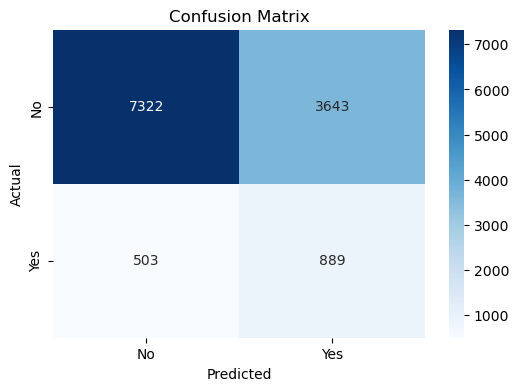

In [35]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

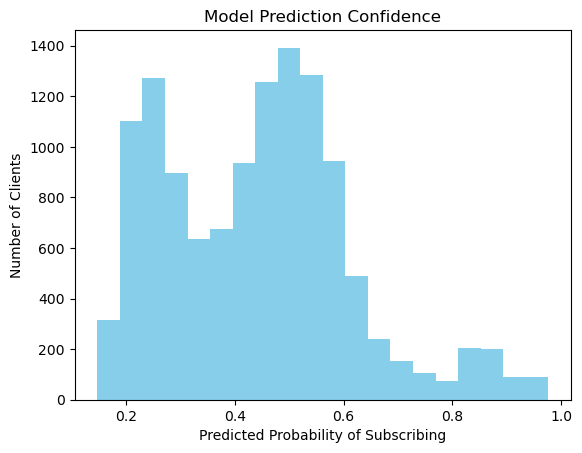

In [37]:
plt.hist(y_proba, bins=20, color='skyblue')
plt.xlabel('Predicted Probability of Subscribing')
plt.ylabel('Number of Clients')
plt.title('Model Prediction Confidence')
plt.show()

### Problem 9: Score the Model

What is the accuracy of your model?

In [39]:
logistic_metrics_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s)
0,Logistic Regression (SMOTE),0.664042,0.664482,0.196161,0.638649,0.300135,0.723218,0.729221,0.2271


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

#### KNeighboors ####

In [41]:
# Train on balanced, preprocessed data
knn_model = KNeighborsClassifier(n_neighbors=15)

# Start timer
start_time = time.time()

# Fit the model on already processed and balanced data
knn_model.fit(X_train_balanced, y_train_balanced)

# End timer
training_time = time.time() - start_time

# Predict on preprocessed original train and test sets
y_train_pred_knn = knn_model.predict(X_train_processed)
y_pred_knn = knn_model.predict(X_test_processed)
y_train_proba_knn = knn_model.predict_proba(X_train_processed)[:, 1]
y_proba_knn = knn_model.predict_proba(X_test_processed)[:, 1]

# Evaluation
knn_metrics = {
    "Model": "K-Nearest Neighbors (SMOTE)",
    "Train Accuracy": accuracy_score(y_train, y_train_pred_knn),
    "Test Accuracy": accuracy_score(y_test, y_pred_knn),
    "Precision": precision_score(y_test, y_pred_knn),
    "Recall": recall_score(y_test, y_pred_knn),
    "F1 Score": f1_score(y_test, y_pred_knn),
    "ROC AUC Train": roc_auc_score(y_train, y_train_proba_knn),
    "ROC AUC Test": roc_auc_score(y_test, y_proba_knn),
    "Training Time (s)": round(training_time, 4)
}

# Create DataFrame for metrics
knn_metrics_df = pd.DataFrame([knn_metrics])
knn_metrics_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s)
0,K-Nearest Neighbors (SMOTE),0.781797,0.733188,0.212496,0.505747,0.299256,0.838649,0.672037,0.0121


#### Decision Tree ####

In [43]:
# Start timer
start_time = time.time()

# Build model
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)

# Fit model on balanced, preprocessed training data
tree_model.fit(X_train_balanced, y_train_balanced)

# End timer
training_time = time.time() - start_time

# Predict on original (unbalanced) preprocessed sets
y_train_pred_tree = tree_model.predict(X_train_processed)
y_pred_tree = tree_model.predict(X_test_processed)
y_train_proba_tree = tree_model.predict_proba(X_train_processed)[:, 1]
y_proba_tree = tree_model.predict_proba(X_test_processed)[:, 1]

# Evaluation
tree_metrics = {
    "Model": "Decision Tree (SMOTE)",
    "Train Accuracy": accuracy_score(y_train, y_train_pred_tree),
    "Test Accuracy": accuracy_score(y_test, y_pred_tree),
    "Precision": precision_score(y_test, y_pred_tree),
    "Recall": recall_score(y_test, y_pred_tree),
    "F1 Score": f1_score(y_test, y_pred_tree),
    "ROC AUC Train": roc_auc_score(y_train, y_train_proba_tree),
    "ROC AUC Test": roc_auc_score(y_test, y_proba_tree),
    "Training Time (s)": round(training_time, 4)
}

# Convert to DataFrame
tree_metrics_df = pd.DataFrame([tree_metrics])
tree_metrics_df


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s)
0,Decision Tree (SMOTE),0.687212,0.688517,0.193105,0.555316,0.286562,0.706073,0.717381,0.1005


#### SVM ####

In [45]:
# Initialize SVM model
svm_model = SVC(probability=True, random_state=42)

# Start timer
start = time.time()

# Fit on balanced, preprocessed training data
svm_model.fit(X_train_balanced, y_train_balanced)

# End timer
end = time.time()

# Predict on original preprocessed data
y_train_pred_svm = svm_model.predict(X_train_processed)
y_pred_svm = svm_model.predict(X_test_processed)
y_train_proba_svm = svm_model.predict_proba(X_train_processed)[:, 1]
y_proba_svm = svm_model.predict_proba(X_test_processed)[:, 1]

# Metrics
svm_metrics = {
    "Model": "SVM (Default + SMOTE)",
    "Train Accuracy": accuracy_score(y_train, y_train_pred_svm),
    "Test Accuracy": accuracy_score(y_test, y_pred_svm),
    "Precision": precision_score(y_test, y_pred_svm),
    "Recall": recall_score(y_test, y_pred_svm),
    "F1 Score": f1_score(y_test, y_pred_svm),
    "ROC AUC Train": roc_auc_score(y_train, y_train_proba_svm),
    "ROC AUC Test": roc_auc_score(y_test, y_proba_svm),
    "Training Time (s)": round(end - start, 4)
}

# Convert to DataFrame
svm_metrics_df = pd.DataFrame([svm_metrics])
svm_metrics_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s)
0,SVM (Default + SMOTE),0.672991,0.666748,0.190509,0.60273,0.28951,0.724516,0.698837,961.9092


In [47]:
comparison_df = pd.concat([
    logistic_metrics_df,
    knn_metrics_df,
    tree_metrics_df,
    svm_metrics_df
], ignore_index=True)

comparison_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s)
0,Logistic Regression (SMOTE),0.664042,0.664482,0.196161,0.638649,0.300135,0.723218,0.729221,0.2271
1,K-Nearest Neighbors (SMOTE),0.781797,0.733188,0.212496,0.505747,0.299256,0.838649,0.672037,0.0121
2,Decision Tree (SMOTE),0.687212,0.688517,0.193105,0.555316,0.286562,0.706073,0.717381,0.1005
3,SVM (Default + SMOTE),0.672991,0.666748,0.190509,0.602730,0.289510,0.724516,0.698837,961.9092


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Grid Search for Logistic Regression ####

In [57]:
def evaluate_with_threshold(model_name, y_true, y_pred_proba, threshold, y_train, y_train_pred, y_train_proba, training_time):
    """
    Evaluates classification metrics at a custom threshold.

    Parameters:
        model_name (str): Name of the model.
        y_true (array): True labels for test set.
        y_pred_proba (array): Predicted probabilities for test set.
        threshold (float): Classification threshold.
        y_train (array): True labels for training set.
        y_train_pred (array): Predicted labels for training set.
        y_train_proba (array): Predicted probabilities for training set.
        training_time (float): Training time in seconds.

    Returns:
        dict: Dictionary of evaluation metrics.
    """
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)

    return {
        "Model": f"{model_name} (threshold={threshold})",
        "Train Accuracy": accuracy_score(y_train, y_train_pred),
        "Test Accuracy": accuracy_score(y_true, y_pred_thresh),
        "Precision": precision_score(y_true, y_pred_thresh, zero_division=0),
        "Recall": recall_score(y_true, y_pred_thresh),
        "F1 Score": f1_score(y_true, y_pred_thresh),
        "ROC AUC Train": roc_auc_score(y_train, y_train_proba),
        "ROC AUC Test": roc_auc_score(y_true, y_pred_proba),
        "Training Time (s)": round(training_time, 4)
    }

In [55]:
# Define model and hyperparameter grid (no pipeline)
logreg = LogisticRegression(max_iter=1000, random_state=42)

logreg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': ['balanced']
}

# Grid search with 5-fold CV
grid_logreg = GridSearchCV(
    logreg,
    logreg_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit using balanced and preprocessed data
grid_logreg.fit(X_train_balanced, y_train_balanced)

# Best model
best_logreg_model = grid_logreg.best_estimator_

# Start timer
start_time = time.time()

# Predict on original preprocessed sets
y_train_pred = best_logreg_model.predict(X_train_processed)
y_pred = best_logreg_model.predict(X_test_processed)
y_train_proba = best_logreg_model.predict_proba(X_train_processed)[:, 1]
y_proba = best_logreg_model.predict_proba(X_test_processed)[:, 1]

# End timer
training_time = round(time.time() - start_time, 4)

# Threshold tuning (change this value as needed)
threshold = 0.4
y_pred_thresh = (y_proba >= threshold).astype(int)

# # Evaluate at custom threshold
# logreg_tuned_metrics = {
#     "Model": f"LogReg (Tuned, threshold={threshold})",
#     "Train Accuracy": accuracy_score(y_train, y_train_pred),
#     "Test Accuracy": accuracy_score(y_test, y_pred_thresh),
#     "Precision": precision_score(y_test, y_pred_thresh),
#     "Recall": recall_score(y_test, y_pred_thresh),
#     "F1 Score": f1_score(y_test, y_pred_thresh),
#     "ROC AUC Train": roc_auc_score(y_train, y_train_proba),
#     "ROC AUC Test": roc_auc_score(y_test, y_proba),
#     "Training Time (s)": training_time
# }

# # Convert to DataFrame
# logreg_tuned_df = pd.DataFrame([logreg_tuned_metrics])
# logreg_tuned_df


Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [70]:
logreg_tuned_metrics = evaluate_with_threshold(
    model_name="LogReg (Tuned)",
    y_true=y_test,
    y_pred_proba=y_proba,
    threshold=0.6,
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_train_proba=y_train_proba,
    training_time=training_time
)

logreg_tuned_df = pd.DataFrame([logreg_tuned_metrics])
logreg_tuned_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s)
0,LogReg (Tuned) (threshold=0.6),0.947279,0.812171,0.232277,0.289511,0.257755,0.94998,0.679313,46.0978


In [61]:
# Thresholds to test
thresholds = np.arange(0.0, 1.01, 0.05)

# Store results
logreg_threshold_data = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)  # y_proba is from logistic regression

    if y_pred_t.sum() == 0:
        continue  # Avoid divide-by-zero when no positives are predicted

    prec = precision_score(y_test, y_pred_t, zero_division=0)
    rec = recall_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)

    logreg_threshold_data.append((t, prec, rec, f1))

# Create DataFrame
logreg_threshold_df = pd.DataFrame(
    logreg_threshold_data, 
    columns=['Threshold', 'Precision', 'Recall', 'F1 Score']
)

# Sort by F1 Score
logreg_threshold_df_sorted = logreg_threshold_df.sort_values(by='F1 Score', ascending=False)

# Display top results
display(logreg_threshold_df_sorted.head(10))


,Threshold,Precision,Recall,F1 Score
11,0.55,0.175513,0.596264,0.271198
10,0.50,0.157516,0.770833,0.261580
12,0.60,0.232277,0.289511,0.257755
9,0.45,0.148752,0.839080,0.252704
8,0.40,0.147250,0.846264,0.250852
7,0.35,0.139600,0.888649,0.241295
6,0.30,0.124894,0.949713,0.220756
0,0.00,0.112649,1.000000,0.202487
1,0.05,0.112649,1.000000,0.202487
2,0.10,0.112649,1.000000,0.202487


/home/sal-dev/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sal-dev/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sal-dev/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sal-dev/anaconda3/lib/python

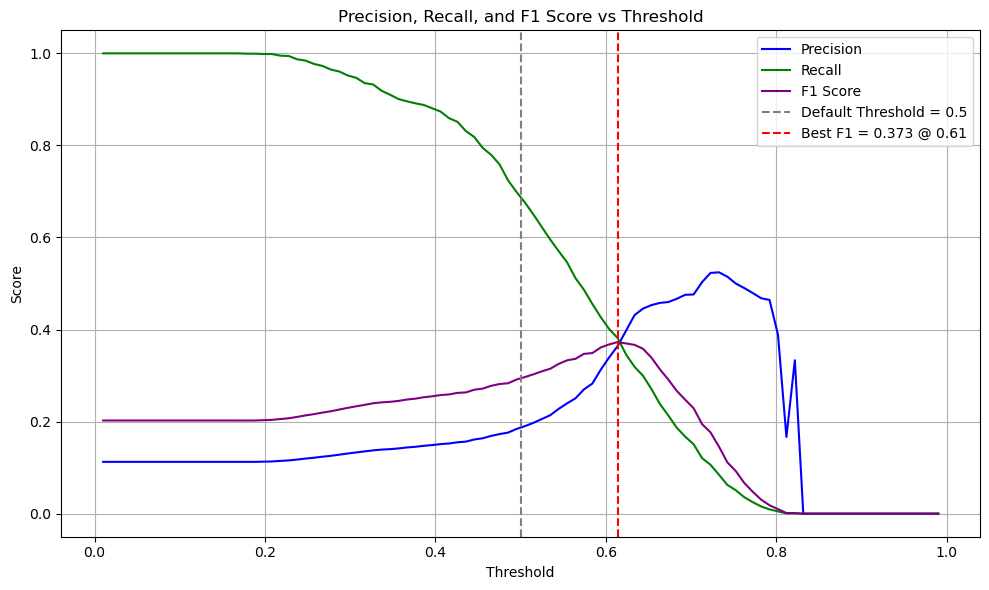

In [54]:
# Generate thresholds
thresholds = np.linspace(0.01, 0.99, 100)

# Lists to hold metric values
precisions = []
recalls = []
f1_scores = []

# Evaluate metrics at each threshold
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_t))
    recalls.append(recall_score(y_test, y_pred_t))
    f1_scores.append(f1_score(y_test, y_pred_t))

# Find threshold with highest F1
best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx]
best_f1 = f1_scores[best_f1_idx]

# Plot all metrics
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.plot(thresholds, f1_scores, label='F1 Score', color='purple')
plt.axvline(0.5, linestyle='--', color='gray', label='Default Threshold = 0.5')
plt.axvline(best_threshold, linestyle='--', color='red', label=f'Best F1 = {best_f1:.3f} @ {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Grid Search for KNeighboors ####

In [69]:
# Define hyperparameter grid
knn_param_grid = {
    'n_neighbors': [5, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    # 'metric': ['euclidean', 'manhattan', 'minkowski']
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1,2]
}

# GridSearchCV using processed and SMOTE-balanced data
knn_model = KNeighborsClassifier()
grid_knn = GridSearchCV(knn_model, knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_knn.fit(X_train_balanced, y_train_balanced)

# Best model
best_knn_model = grid_knn.best_estimator_

# Timer
start_time = time.time()

# Predictions
y_train_pred = best_knn_model.predict(X_train_processed)
y_pred = best_knn_model.predict(X_test_processed)
y_train_proba = best_knn_model.predict_proba(X_train_processed)[:, 1]
y_test_proba = best_knn_model.predict_proba(X_test_processed)[:, 1]

# End timer
training_time = round(time.time() - start_time, 4)

# Metrics
knn_tuned_metrics = {
    "Model": "KNN (Tuned)",
    "Train Accuracy": accuracy_score(y_train, y_train_pred),
    "Test Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "ROC AUC Train": roc_auc_score(y_train, y_train_proba),
    "ROC AUC Test": roc_auc_score(y_test, y_test_proba),
    "Training Time (s)": training_time
}

# Convert to DataFrame
knn_tuned_df = pd.DataFrame([knn_tuned_metrics])
knn_tuned_df

Fitting 5 folds for each of 64 candidates, totalling 320 fits


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s)
0,KNN (Tuned),0.947279,0.841952,0.288621,0.275144,0.281721,0.94998,0.629078,46.0978


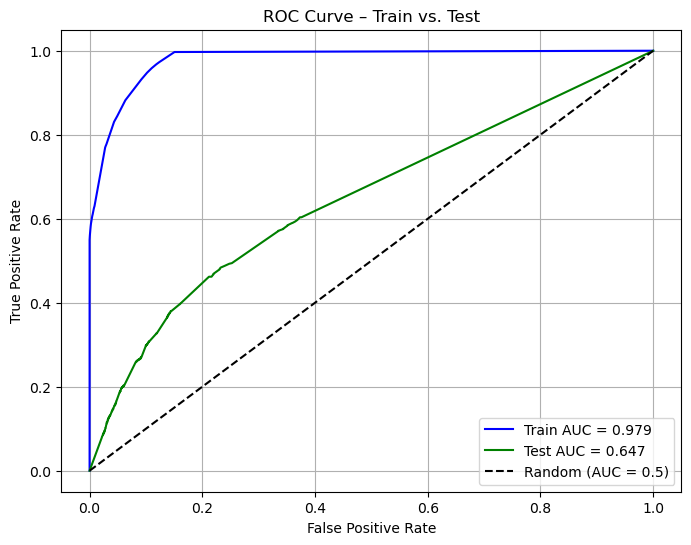

In [43]:
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

# Get ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

# Plot both curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {train_auc:.3f}', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {test_auc:.3f}', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Train vs. Test')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### Gridsearch DecisionTree ####

In [73]:
# Define the model
tree_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Define hyperparameter grid
tree_param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [3, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Grid search
grid_tree = GridSearchCV(tree_model, tree_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
start_time = time.time()
grid_tree.fit(X_train_balanced, y_train_balanced)
training_time = round(time.time() - start_time, 4)

# Best model
best_tree_model = grid_tree.best_estimator_

# Predict
y_train_pred_tree = best_tree_model.predict(X_train_processed)
y_pred_tree = best_tree_model.predict(X_test_processed)
y_train_proba_tree = best_tree_model.predict_proba(X_train_processed)[:, 1]
y_proba_tree = best_tree_model.predict_proba(X_test_processed)[:, 1]

# Metrics
tree_tuned_metrics = {
    "Model": "Decision Tree (Tuned)",
    "Train Accuracy": accuracy_score(y_train, y_train_pred_tree),
    "Test Accuracy": accuracy_score(y_test, y_pred_tree),
    "Precision": precision_score(y_test, y_pred_tree),
    "Recall": recall_score(y_test, y_pred_tree),
    "F1 Score": f1_score(y_test, y_pred_tree),
    "ROC AUC Train": roc_auc_score(y_train, y_train_proba_tree),
    "ROC AUC Test": roc_auc_score(y_test, y_proba_tree),
    "Training Time (s)": training_time
}

# To DataFrame
tree_tuned_df = pd.DataFrame([tree_tuned_metrics])
tree_tuned_df


Fitting 5 folds for each of 72 candidates, totalling 360 fits


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s)
0,Decision Tree (Tuned),0.870833,0.86801,0.400167,0.344109,0.370027,0.757002,0.721571,10.7601


In [ ]:
# Define the SVM model (no probabilities for speed)
svm_model = SVC(class_weight='balanced', random_state=42)

# Define the parameter grid
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Grid search with cross-validation
grid_svm = GridSearchCV(
    svm_model,
    svm_param_grid,
    cv=5,
    scoring='recall',  # or 'roc_auc', 'recall', etc.
    n_jobs=-1,
    verbose=1
)

# Train the model
start_time = time.time()
grid_svm.fit(X_train_balanced, y_train_balanced)
training_time = round(time.time() - start_time, 4)

# Best estimator
best_svm_model = grid_svm.best_estimator_

# Predict
y_train_pred_svm = best_svm_model.predict(X_train_processed)
y_pred_svm = best_svm_model.predict(X_test_processed)

# Use decision_function for ROC AUC (no predict_proba here)
y_train_scores_svm = best_svm_model.decision_function(X_train_processed)
y_test_scores_svm = best_svm_model.decision_function(X_test_processed)

# Metrics
svm_tuned_metrics = {
    "Model": "SVM (Tuned)",
    "Train Accuracy": accuracy_score(y_train, y_train_pred_svm),
    "Test Accuracy": accuracy_score(y_test, y_pred_svm),
    "Precision": precision_score(y_test, y_pred_svm),
    "Recall": recall_score(y_test, y_pred_svm),
    "F1 Score": f1_score(y_test, y_pred_svm),
    "ROC AUC Train": roc_auc_score(y_train, y_train_scores_svm),
    "ROC AUC Test": roc_auc_score(y_test, y_test_scores_svm),
    "Training Time (s)": training_time
}

# Results DataFrame
svm_tuned_df = pd.DataFrame([svm_tuned_metrics])
svm_tuned_df

Fitting 5 folds for each of 12 candidates, totalling 60 fits


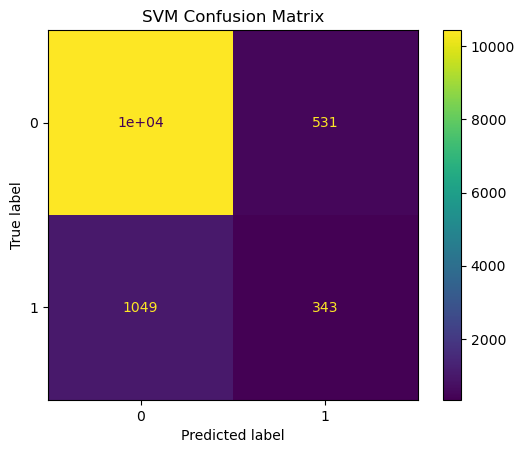

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("SVM Confusion Matrix")
plt.show()

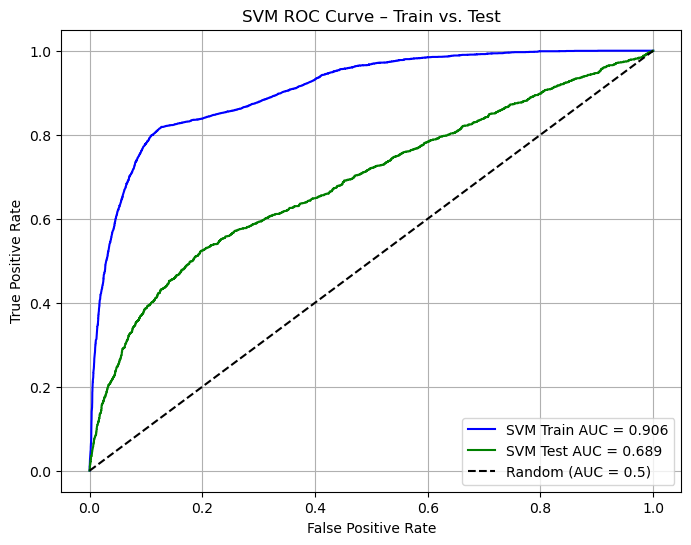

In [57]:
# Calculate AUC scores for SVM
svm_train_auc = roc_auc_score(y_train, y_train_scores_svm)
svm_test_auc = roc_auc_score(y_test, y_test_scores_svm)

# Get ROC curves
fpr_train_svm, tpr_train_svm, _ = roc_curve(y_train, y_train_scores_svm)
fpr_test_svm, tpr_test_svm, _ = roc_curve(y_test, y_test_scores_svm)

# Plot both curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_train_svm, tpr_train_svm, label=f'SVM Train AUC = {svm_train_auc:.3f}', color='blue')
plt.plot(fpr_test_svm, tpr_test_svm, label=f'SVM Test AUC = {svm_test_auc:.3f}', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve – Train vs. Test')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
all_models_df = pd.concat([
    logreg_tuned_df,
    knn_tuned_df,
    tree_tuned_df,
    svm_tuned_df
], ignore_index=True)

# Display the combined table
all_models_df

##### Questions